# **Network Visualization for Football Data**

## **Objective**
Create comprehensive visualizations of football passing networks to analyze team performance patterns.

## **Steps**
1. Load network data (summaries, edges, player positions)
2. Create pitch drawing functions for realistic field layouts
3. Develop multiple visualization styles:
   - Basic passing networks
   - Density maps showing ball concentration
   - Centrality analysis highlighting key players
   - Betweenness analysis showing playmakers
4. Generate example visualizations for wins and losses

## **Output**
- Interactive visualization functions
- Sample network visualizations saved as PNG files
- Analysis tools for different network metrics

## **1. Environment Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import networkx as nx
import seaborn as sns
import warnings
from pathlib import Path
from typing import Tuple, Optional, Dict, List
from collections import defaultdict
from scipy.stats import gaussian_kde

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## **2. Data Loading**

In [2]:
DATA_PATH = Path("../data")
PROCESSED_DATA_PATH = DATA_PATH / "processed"
VIZ_PATH = Path('..') / 'viz'
VIZ_PATH.mkdir(parents=True, exist_ok=True)

print("Loading network data...")
network_summary = pd.read_parquet(PROCESSED_DATA_PATH / "on_ball_networks.parquet")
network_edges = pd.read_parquet(PROCESSED_DATA_PATH / "network_edges.parquet")
player_positions = pd.read_parquet(PROCESSED_DATA_PATH / "player_positions.parquet")

print(f"✓ Network summaries loaded: {len(network_summary)}")
print(f"✓ Network edges loaded: {len(network_edges)}")
print(f"✓ Player positions loaded: {len(player_positions)}")

Loading network data...
✓ Network summaries loaded: 4050
✓ Network edges loaded: 479129
✓ Player positions loaded: 56979


## **3. Pitch Drawing Functions**

In [3]:
def draw_statsbomb_pitch(ax,
                         pitch_length=120, pitch_width=80,
                         origin_x=0, origin_y=0,
                         line_color="black", pitch_color="white",
                         linewidth=1, alpha=1, 
                         draw_background=True,
                         background_alpha=1):
    from matplotlib import patches
    
    if draw_background:
        pitch = patches.Rectangle(
            (origin_x, origin_y),
            pitch_length,
            pitch_width,
            edgecolor='none',
            facecolor=pitch_color,
            alpha=background_alpha,
            zorder=0
        )
        ax.add_patch(pitch)
    
    border_lines = [
        ([origin_x, origin_x + pitch_length], [origin_y, origin_y]),
        ([origin_x + pitch_length, origin_x + pitch_length], [origin_y, origin_y + pitch_width]),
        ([origin_x + pitch_length, origin_x], [origin_y + pitch_width, origin_y + pitch_width]),
        ([origin_x, origin_x], [origin_y + pitch_width, origin_y])
    ]
    
    for x_coords, y_coords in border_lines:
        ax.plot(x_coords, y_coords, color=line_color, lw=linewidth, alpha=alpha, zorder=2)
    
    ax.plot([origin_x + pitch_length/2, origin_x + pitch_length/2],
            [origin_y, origin_y + pitch_width],
            color=line_color, lw=linewidth, alpha=alpha, zorder=2)

    center = (origin_x + pitch_length/2, origin_y + pitch_width/2)
    center_circle = patches.Circle(center, radius=10, fill=False,
                                   edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2)
    ax.add_patch(center_circle)
    ax.plot(center[0], center[1], marker='o', markersize=4,
            color=line_color, alpha=alpha, zorder=2)

    left_penalty = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_penalty)
    right_penalty = patches.Rectangle(
        (origin_x + pitch_length - 18, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_penalty)

    left_six = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_six)
    right_six = patches.Rectangle(
        (origin_x + pitch_length - 6, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_six)

    ax.plot(origin_x + 12, origin_y + pitch_width/2,
            marker='o', markersize=4, color=line_color, alpha=alpha, zorder=2)
    ax.plot(origin_x + pitch_length - 12, origin_y + pitch_width/2,
            marker='o', markersize=4, color=line_color, alpha=alpha, zorder=2)

    left_arc = patches.Arc(
        (origin_x + 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=-53,
        theta2=53,
        color=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_arc)
    right_arc = patches.Arc(
        (origin_x + pitch_length - 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=127,
        theta2=233,
        color=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_arc)

    goal_width = 8
    goal_offset = 2
    left_goal = patches.Rectangle(
        (origin_x - goal_offset, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_goal)
    right_goal = patches.Rectangle(
        (origin_x + pitch_length, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_goal)

    ax.set_xlim(origin_x - goal_offset - 5, origin_x + pitch_length + goal_offset + 5)
    ax.set_ylim(origin_y - 5, origin_y + pitch_width + 5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.invert_yaxis()

## **4. Basic Network Visualization**

In [4]:
def visualize_basic_network(network_summary: pd.DataFrame, 
                           network_edges: pd.DataFrame, 
                           player_positions: pd.DataFrame,
                           match_id: Optional[int] = None, 
                           team: Optional[str] = None, 
                           random_selection: bool = False, 
                           final_result: Optional[int] = None,
                           save_path: Optional[Path] = None) -> Tuple[plt.Figure, plt.Axes]:
    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]
        if filtered_networks.empty:
            raise ValueError(f"No networks found with final_result={final_result}")
    if random_selection:
        if filtered_networks.empty:
            raise ValueError("No networks available after filtering")
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']
    network_info = network_summary[
        (network_summary['match_id'] == match_id) & 
        (network_summary['team'] == team)
    ]
    if network_info.empty:
        raise ValueError(f"No data found for match_id={match_id}, team={team}")
    network_info = network_info.iloc[0]
    result = network_info.get('final_result', 0)
    win_color = '#06478f'
    lose_color = '#b01f16'
    node_color = win_color if result == 1 else lose_color
    result_suffix = 'W' if result == 1 else 'L'
    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    print(main_title)
    print(subtitle)
    team_positions = player_positions[
        (player_positions['match_id'] == match_id) & 
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) & 
        (network_edges['team'] == team)
    ]
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_statsbomb_pitch(ax)
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name
    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:
            continue
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {'weight': weight, 'bidirectional': False, 'source': source, 'target': target}
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight
    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    for (u, v), info in bidirectional_edges.items():
        weight = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=weight)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=weight)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(weight)
    if edge_weights:
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [
            0.5 + 1.5 * (w - min_weight) / (max_weight - min_weight + 1e-6)
            for w in edge_weights
        ]
    else:
        edge_widths = [0.5] * len(edge_list)
    for (u, v), width, is_bidirectional in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        arrow_style = '<->' if is_bidirectional else '->'
        ax.annotate(
            '', xy=pos[v], xytext=pos[u],
            arrowprops=dict(
                arrowstyle=arrow_style, color=node_color, alpha=0.85, lw=width,
                connectionstyle='arc3,rad=0.2', shrinkA=20, shrinkB=20
            )
        )
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_size=700, node_color=node_color,
        edgecolors='black', linewidths=0.8
    )
    nodes.set_zorder(10)
    for player_id, (x, y) in pos.items():
        text = ax.text(
            x, y, node_labels[player_id], fontsize=14,
            fontweight='bold', ha='center', va='center',
            color='white', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    return fig, ax

## **5. Density Map Visualization**

In [5]:
def visualize_network_with_density(network_summary: pd.DataFrame,
                                   network_edges: pd.DataFrame,
                                   player_positions: pd.DataFrame,
                                   match_id: Optional[int] = None,
                                   team: Optional[str] = None,
                                   random_selection: bool = False,
                                   final_result: Optional[int] = None,
                                   save_path: Optional[Path] = None) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:

    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]

    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']

    network_info = network_summary[
        (network_summary['match_id'] == match_id) &
        (network_summary['team'] == team)
    ].iloc[0]

    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'

    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    print(main_title)
    print(subtitle)

    team_positions = player_positions[
        (player_positions['match_id'] == match_id) &
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) &
        (network_edges['team'] == team)
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2, draw_background=False)

    G = nx.DiGraph()
    pos = {}
    node_labels = {}

    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name

    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:
            continue
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {'weight': weight, 'bidirectional': False, 'source': source, 'target': target}
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight

    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    for (u, v), info in bidirectional_edges.items():
        w = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=w)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=w)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(w)

    if edge_weights:
        mn, mx = min(edge_weights), max(edge_weights)
        edge_widths = [0.5 + 1.5 * (w - mn) / (mx - mn + 1e-6) for w in edge_weights]
    else:
        edge_widths = [0.5] * len(edge_list)

    for (u, v), width, bi in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        arrow_style = '<->' if bi else '->'
        ax1.annotate('', xy=pos[v], xytext=pos[u],
                     arrowprops=dict(arrowstyle=arrow_style, color=node_color,
                                     alpha=0.85, lw=width,
                                     connectionstyle='arc3,rad=0.2',
                                     shrinkA=20, shrinkB=20))

    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=900,
                           node_color=node_color,
                           edgecolors='black', linewidths=0.8).set_zorder(10)

    for pid, (x, y) in pos.items():
        txt = ax1.text(x, y, node_labels[pid], fontsize=16,
                       fontweight='bold', ha='center', va='center',
                       color='white', zorder=20)
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                              path_effects.Normal()])

    density_x, density_y = [], []
    for x, y in pos.values():
        density_x += [x] * 5
        density_y += [y] * 5
    for (u, v), w in zip(edge_list, edge_weights):
        if u not in pos or v not in pos:
            continue
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        pts = max(10, int(w * 15))
        for i in range(pts):
            t = i / (pts - 1) if pts > 1 else 0
            density_x.append(x1 + t * (x2 - x1))
            density_y.append(y1 + t * (y2 - y1))

    if len(density_x) > 3:
        xy = np.vstack([density_x, density_y])
        kde = gaussian_kde(xy, bw_method=0.3)
        xx, yy = np.mgrid[0:120:80j, 0:80:60j]
        pos_grid = np.vstack([xx.ravel(), yy.ravel()])
        z = kde(pos_grid).reshape(xx.shape)
        rgb = mcolors.hex2color(node_color) if isinstance(node_color, str) else node_color
        colors = [(1, 1, 1, 0.0), rgb + (0.8,)]
        from matplotlib.colors import LinearSegmentedColormap
        cmap = LinearSegmentedColormap.from_list('density', colors, N=256)
        levels = np.linspace(z.min(), z.max(), 7)
        ax2.contourf(xx, yy, z, levels=levels, cmap=cmap, extend='max', zorder=1)

    for pid, (x, y) in pos.items():
        ax2.plot(x, y, 'o', color='white', markersize=12,
                 markeredgecolor='black', markeredgewidth=2)
        txt = ax2.text(x, y, node_labels[pid], fontsize=16,
                       fontweight='bold', ha='center', va='center',
                       color='black', zorder=20)
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                              path_effects.Normal()])

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")

    return fig, (ax1, ax2)

## **6. Generate Example Visualizations**

=== GENERATING BASIC NETWORK EXAMPLES ===

Creating win example 1/3...
FSV MAINZ 05 (W)
VfB Stuttgart vs FSV Mainz 05


NetworkXError: Node 20871.0 has no position.

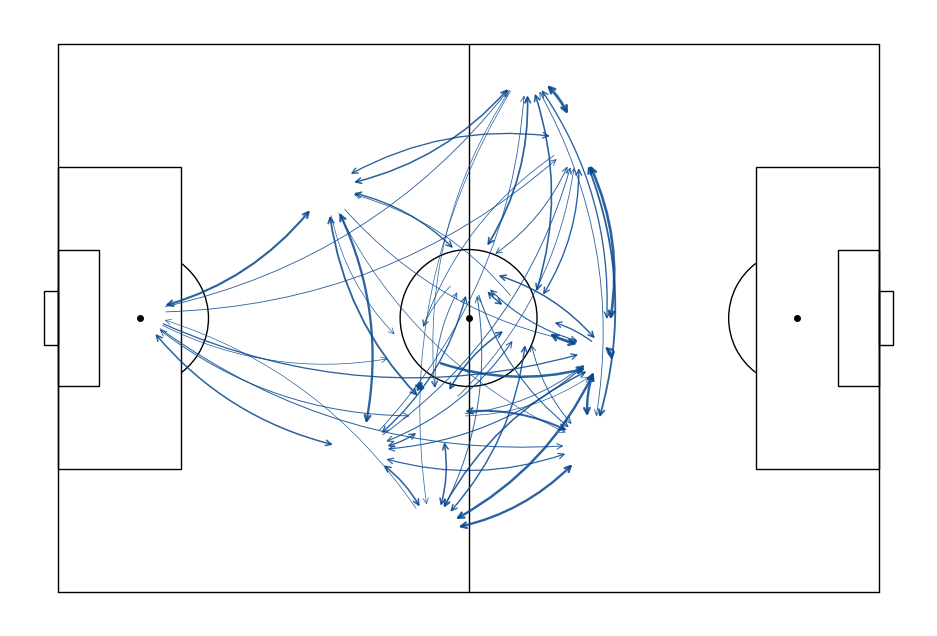

In [6]:
print("=== GENERATING BASIC NETWORK EXAMPLES ===")

for i in range(3):
    print(f"\nCreating win example {i+1}/3...")
    fig_win, ax_win = visualize_basic_network(
        network_summary, network_edges, player_positions,
        random_selection=True, final_result=1
    )
    
    plt.show()
    
    save_path = VIZ_PATH / f"network_basic_win_{i+1}.png"
    fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Basic win network {i+1} saved to: {save_path}")
    plt.close(fig_win)

for i in range(3):
    print(f"\nCreating loss example {i+1}/3...")
    fig_loss, ax_loss = visualize_basic_network(
        network_summary, network_edges, player_positions,
        random_selection=True, final_result=0
    )
    
    plt.show()
    
    save_path = VIZ_PATH / f"network_basic_loss_{i+1}.png"
    fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Basic loss network {i+1} saved to: {save_path}")
    plt.close(fig_loss)


=== GENERATING DENSITY MAP EXAMPLES ===

Creating density map - win example...
DENMARK (W)
Czech Republic vs Denmark


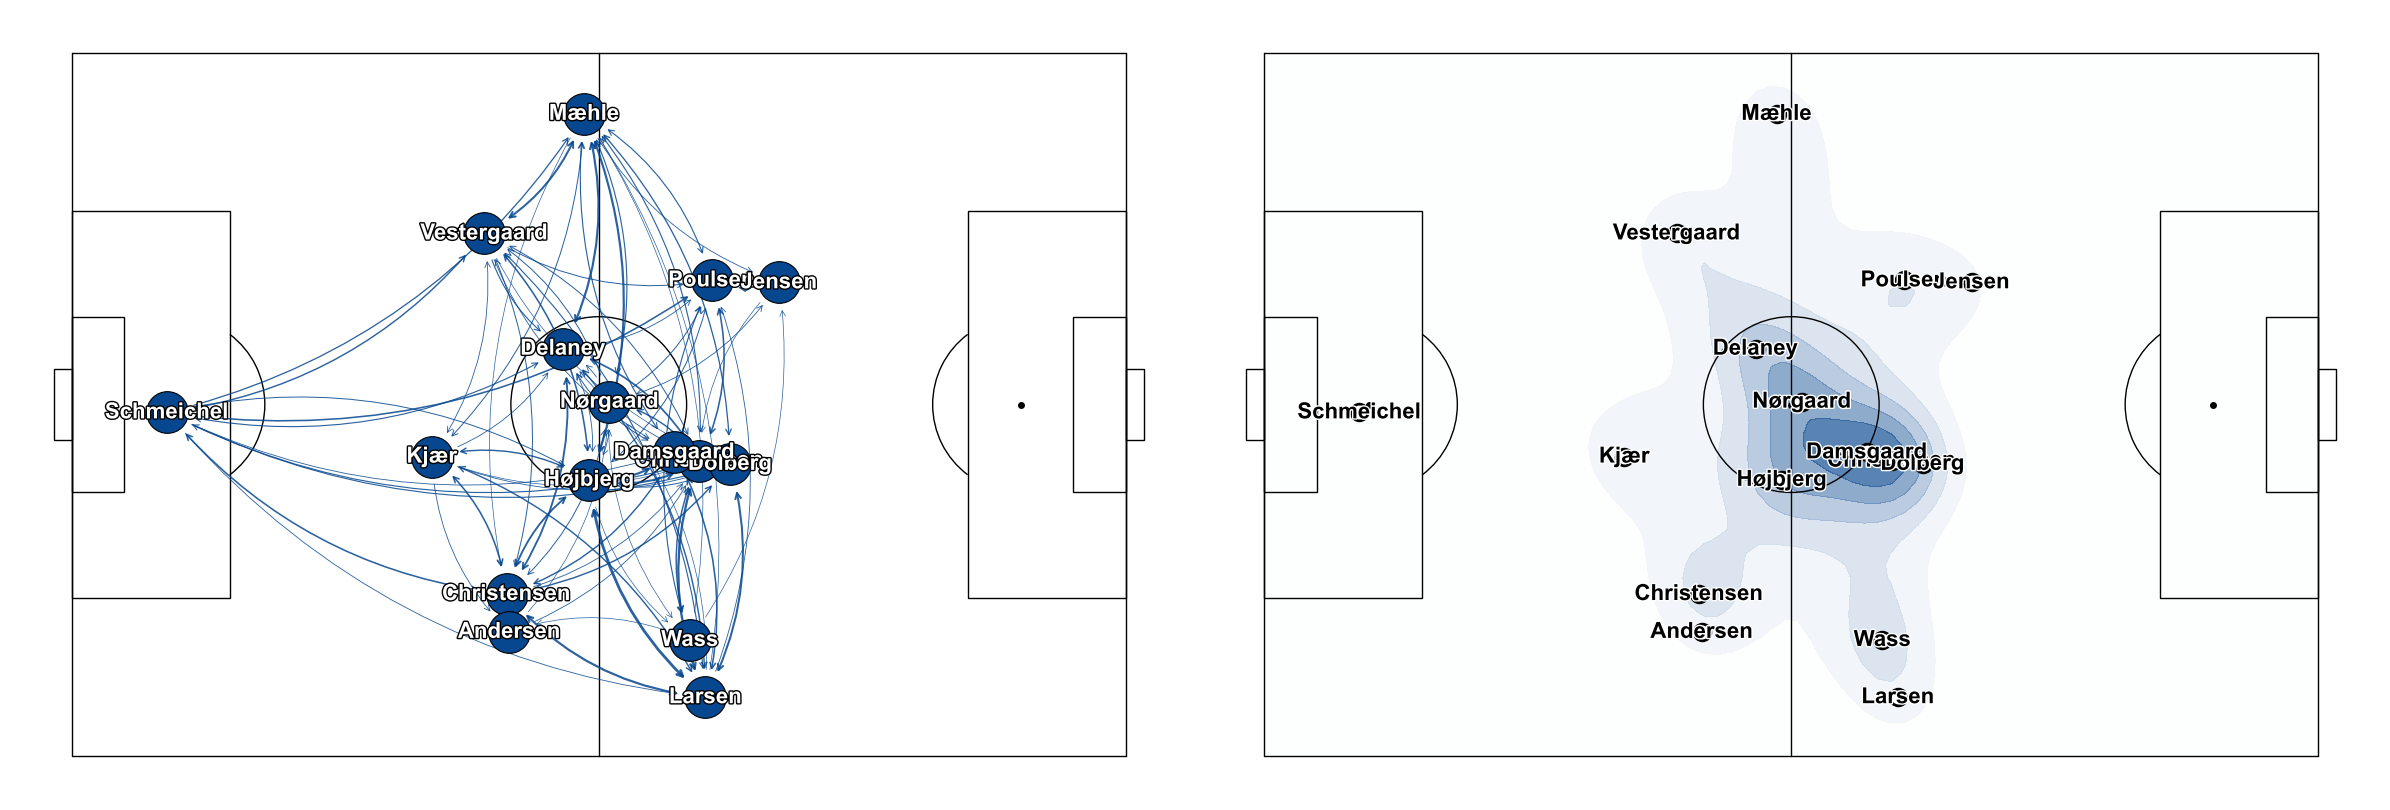

✓ Density win visualization saved to: ..\viz\network_density_win.png

Creating density map - loss example...
NAMIBIA (L)
Angola vs Namibia


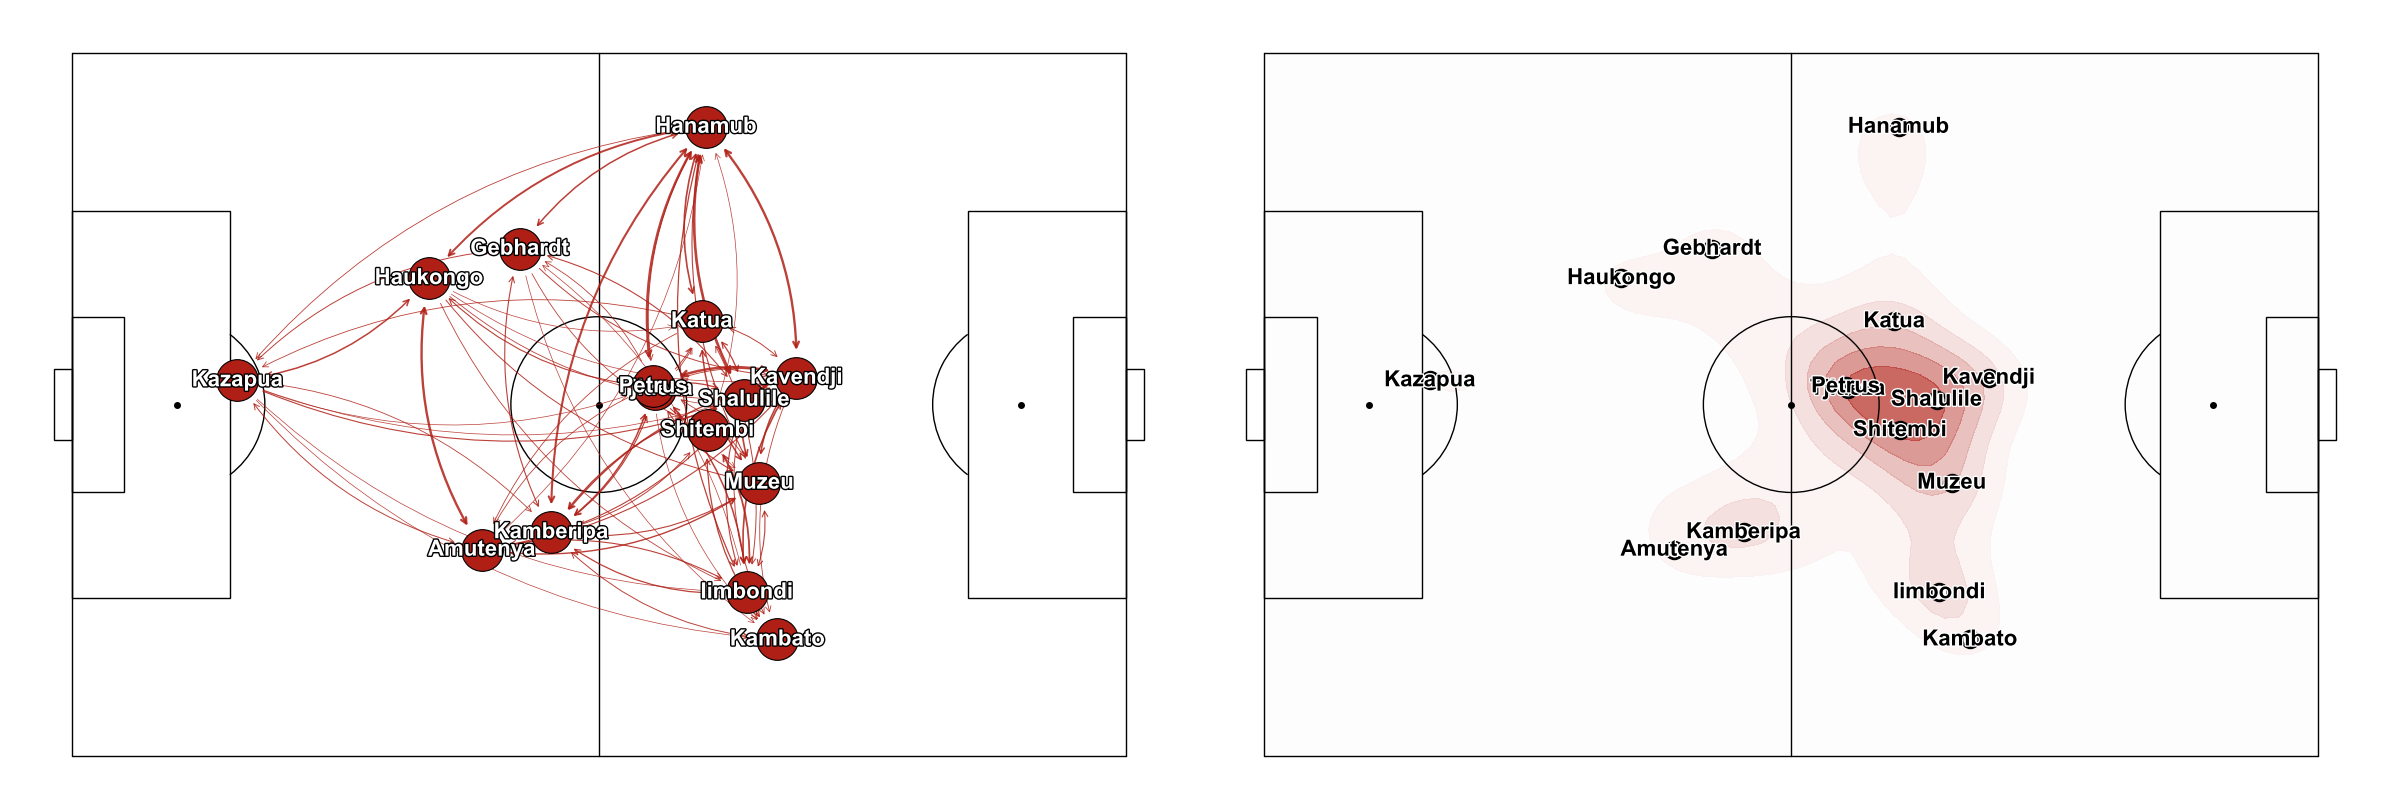

✓ Density loss visualization saved to: ..\viz\network_density_loss.png


In [ ]:
#PASSING NETWORK AND DENSITY MAP
print("\n=== GENERATING DENSITY MAP EXAMPLES ===")

print("\nCreating density map - win example...")
fig_win_density, axes_win = visualize_network_with_density(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_density_win.png"
fig_win_density.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Density win visualization saved to: {save_path}")
plt.close(fig_win_density)

print("\nCreating density map - loss example...")
fig_loss_density, axes_loss = visualize_network_with_density(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_density_loss.png"
fig_loss_density.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Density loss visualization saved to: {save_path}")
plt.close(fig_loss_density)

## **7. Advanced Centrality Visualization**

In [ ]:
def visualize_centrality_analysis(network_summary: pd.DataFrame,
                                 network_edges: pd.DataFrame,
                                 player_positions: pd.DataFrame,
                                 centrality_type: str = 'degree',
                                 match_id: Optional[int] = None,
                                 team: Optional[str] = None,
                                 random_selection: bool = False,
                                 final_result: Optional[int] = None,
                                 save_path: Optional[Path] = None,
                                 top_connections_per_player: int = 2) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:

    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]

    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']

    network_info = network_summary[
        (network_summary['match_id'] == match_id) &
        (network_summary['team'] == team)
    ].iloc[0]

    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'

    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    print(main_title)
    print(subtitle)

    team_positions = player_positions[
        (player_positions['match_id'] == match_id) &
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) &
        (network_edges['team'] == team)
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2)

    G = nx.DiGraph()
    pos = {}
    node_labels = {}

    for _, player in team_positions.iterrows():
        pid = player['player_id']
        name = player['player'].split()[-1]
        G.add_node(pid)
        pos[pid] = (player['location_x'], player['location_y'])
        node_labels[pid] = name

    bidir = {}
    for _, edge in team_edges.iterrows():
        u, v, w = edge['source_id'], edge['target_id'], edge['weight']
        if u == v: continue
        key = tuple(sorted([u, v]))
        if key not in bidir:
            bidir[key] = {'weight': w, 'bi': False, 'u': u, 'v': v}
        else:
            bidir[key]['bi'] = True
            bidir[key]['weight'] += w

    edge_list, weights, flags = [], [], []
    for key, info in bidir.items():
        w = info['weight']
        if info['bi']:
            G.add_edge(key[0], key[1], weight=w)
            edge_list.append((key[0], key[1]))
            flags.append(True)
        else:
            G.add_edge(info['u'], info['v'], weight=w)
            edge_list.append((info['u'], info['v']))
            flags.append(False)
        weights.append(w)

    if weights:
        mn, mx = min(weights), max(weights)
        widths = [0.5 + 1.5*(w-mn)/(mx-mn+1e-6) for w in weights]
    else:
        widths = [0.5]*len(edge_list)

    for (u, v), lw, bi in zip(edge_list, widths, flags):
        if u not in pos or v not in pos: continue
        style = '<->' if bi else '->'
        ax1.annotate('', xy=pos[v], xytext=pos[u],
                     arrowprops=dict(arrowstyle=style, color=node_color,
                                     alpha=0.85, lw=lw,
                                     connectionstyle='arc3,rad=0.2',
                                     shrinkA=20, shrinkB=20))

    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=900,
                           node_color=node_color,
                           edgecolors='black', linewidths=0.8).set_zorder(10)

    for pid, (x, y) in pos.items():
        t = ax1.text(x, y, node_labels[pid], fontsize=16,
                     fontweight='bold', ha='center', va='center',
                     color='white', zorder=20)
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                            path_effects.Normal()])

    from collections import defaultdict
    connections = defaultdict(list)
    degree = defaultdict(int)
    for (u, v), w in zip(edge_list, weights):
        if u in pos and v in pos:
            connections[u].append((v, w))
            connections[v].append((u, w))
            degree[u] += w
            degree[v] += w

    key_players = set()
    if degree:
        dmax, dmin = max(degree.values()), min(degree.values())
        for pid in pos:
            norm = (degree.get(pid,0)-dmin)/(dmax-dmin+1e-6)
            if norm > 0.7:
                key_players.add(pid)

    top_edges, top_weights = [], []
    for pid, conns in connections.items():
        conns.sort(key=lambda x: x[1], reverse=True)
        for tgt, w in conns[:top_connections_per_player]:
            if not any(e==(tgt,pid) for e in top_edges):
                top_edges.append((pid, tgt))
                top_weights.append(w)

    if top_weights:
        mn2, mx2 = min(top_weights), max(top_weights)
        lw2 = [1.0+3.0*(w-mn2)/(mx2-mn2+1e-6) for w in top_weights]
    else:
        lw2 = [1.0]*len(top_edges)

    for (u, v), lw in zip(top_edges, lw2):
        if u not in pos or v not in pos: continue
        ax2.plot([pos[u][0],pos[v][0]], [pos[u][1],pos[v][1]],
                 color=node_color, alpha=0.9, linewidth=lw, zorder=5)

    regular = [pid for pid in pos if pid not in key_players]
    important = [pid for pid in pos if pid in key_players]

    if regular:
        nx.draw_networkx_nodes(G, pos, nodelist=regular, ax=ax2,
                               node_size=900, node_color=node_color,
                               edgecolors='black', linewidths=0.8).set_zorder(10)
    if important:
        nx.draw_networkx_nodes(G, pos, nodelist=important, ax=ax2,
                               node_size=900, node_color=node_color,
                               edgecolors='gold', linewidths=3).set_zorder(10)

    for pid, (x, y) in pos.items():
        t = ax2.text(x, y, node_labels[pid], fontsize=16,
                     fontweight='bold', ha='center', va='center',
                     color='white', zorder=20)
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                            path_effects.Normal()])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")

    return fig, (ax1, ax2)


=== GENERATING CENTRALITY ANALYSIS EXAMPLES ===

Creating degree centrality - win example...
BORDEAUX (W)
Bordeaux vs Rennes


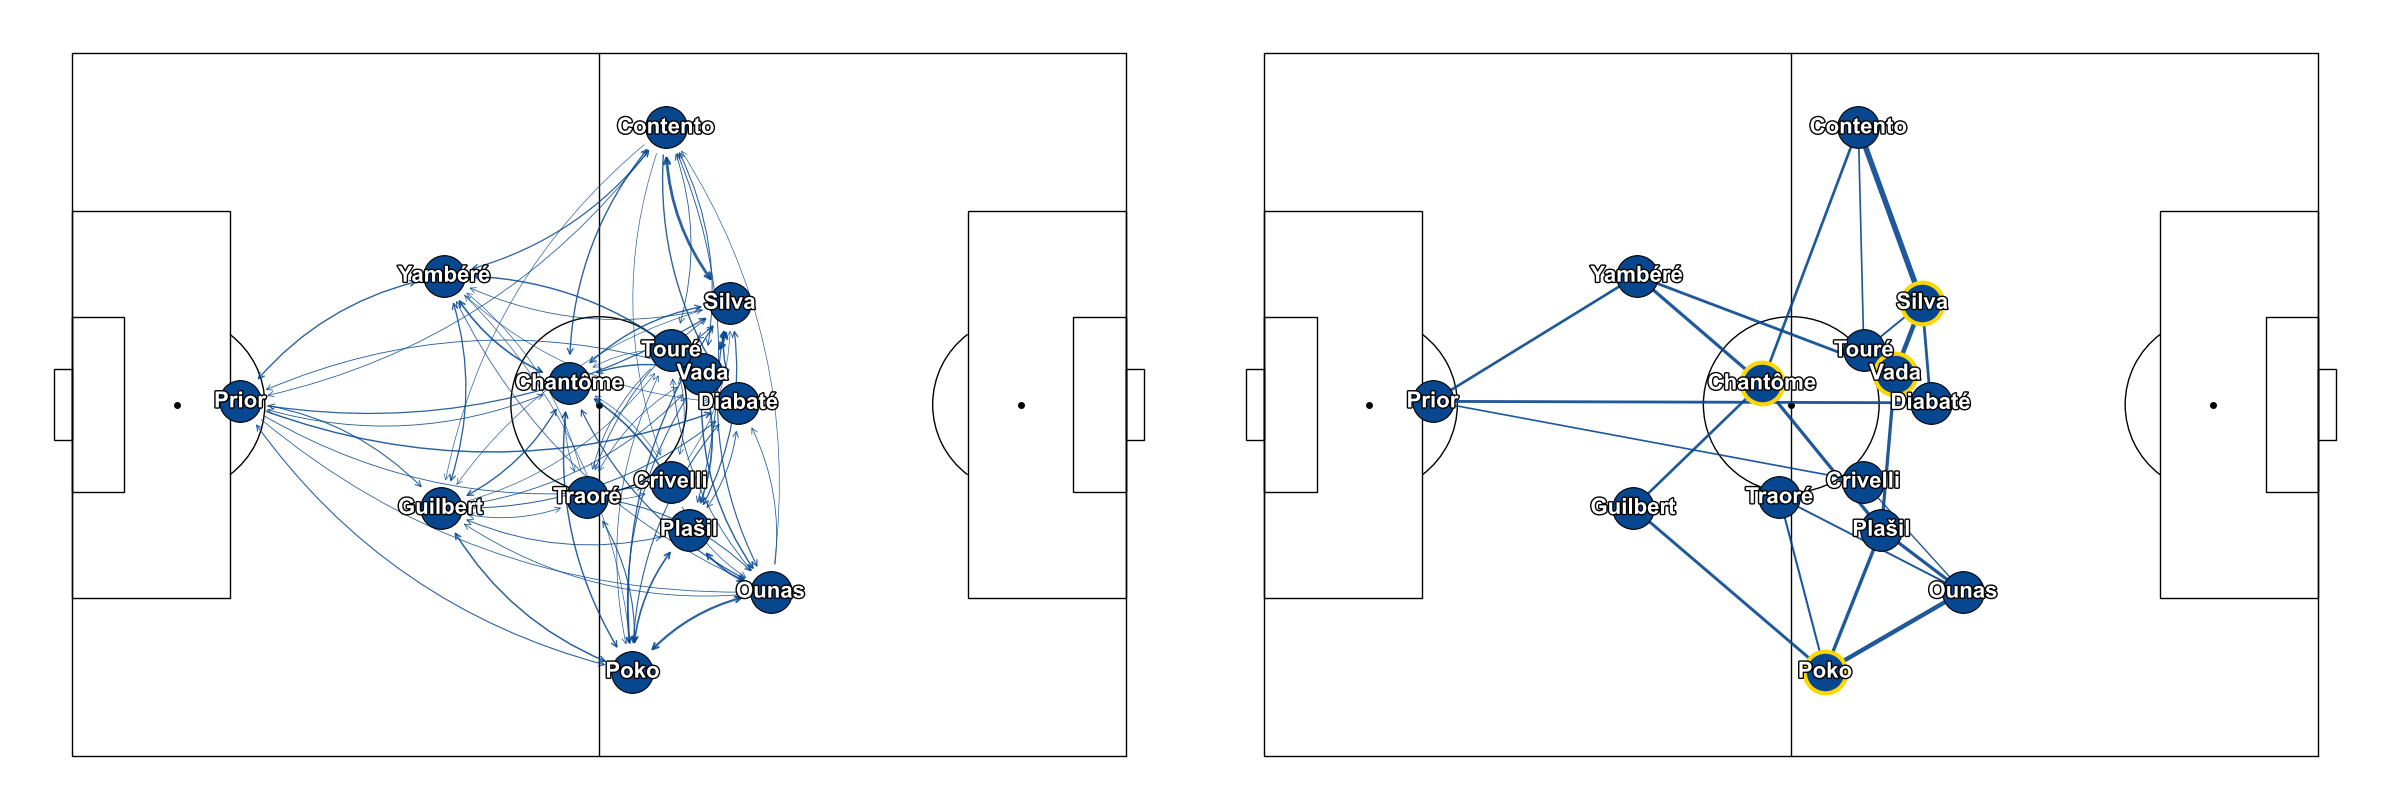

✓ Degree win visualization saved to: ..\viz\network_degree_win.png

Creating degree centrality - loss example...
OSASUNA (L)
Barcelona vs Osasuna


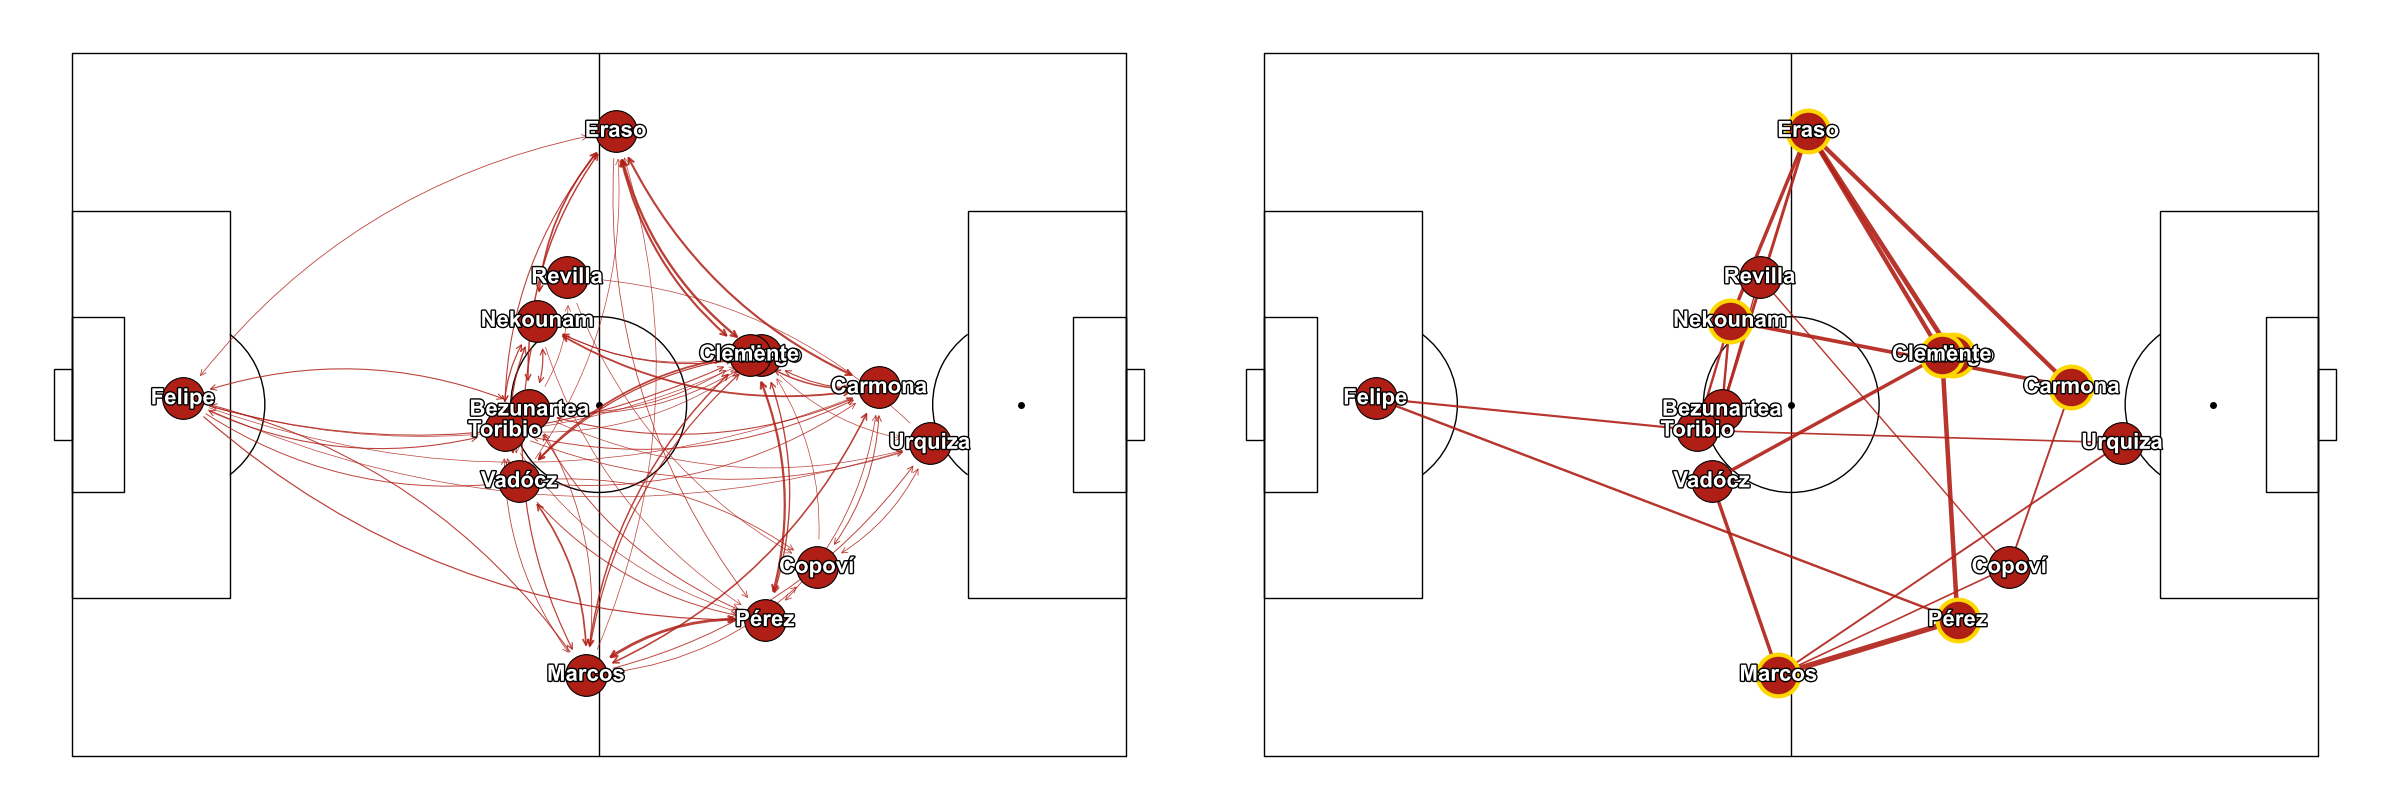

✓ Degree loss visualization saved to: ..\viz\network_degree_loss.png


In [ ]:
print("\n=== GENERATING CENTRALITY ANALYSIS EXAMPLES ===")

print("\nCreating degree centrality - win example...")
fig_win, axes_win = visualize_centrality_analysis(
    network_summary, network_edges, player_positions,
    centrality_type='degree', random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_degree_win.png"
fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Degree win visualization saved to: {save_path}")
plt.close(fig_win)

print("\nCreating degree centrality - loss example...")
fig_loss, axes_loss = visualize_centrality_analysis(
    network_summary, network_edges, player_positions,
    centrality_type='degree', random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_degree_loss.png"
fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Degree loss visualization saved to: {save_path}")
plt.close(fig_loss)

## **8. Betweenness Centrality Visualization**

In [ ]:
def visualize_betweenness_analysis(network_summary: pd.DataFrame,
                                  network_edges: pd.DataFrame,
                                  player_positions: pd.DataFrame,
                                  match_id: Optional[int] = None,
                                  team: Optional[str] = None,
                                  random_selection: bool = False,
                                  final_result: Optional[int] = None,
                                  save_path: Optional[Path] = None,
                                  top_connections_per_player: int = 2) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:

    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]

    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']

    network_info = network_summary[
        (network_summary['match_id'] == match_id) &
        (network_summary['team'] == team)
    ].iloc[0]

    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'

    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    print(main_title)
    print(subtitle)

    team_positions = player_positions[
        (player_positions['match_id'] == match_id) &
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) &
        (network_edges['team'] == team)
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2)

    G = nx.DiGraph()
    pos = {}
    node_labels = {}

    for _, player in team_positions.iterrows():
        pid = player['player_id']
        name = player['player'].split()[-1]
        G.add_node(pid)
        pos[pid] = (player['location_x'], player['location_y'])
        node_labels[pid] = name

    bidir = {}
    for _, edge in team_edges.iterrows():
        u, v, w = edge['source_id'], edge['target_id'], edge['weight']
        if u == v:
            continue
        key = tuple(sorted([u, v]))
        if key not in bidir:
            bidir[key] = {'weight': w, 'bi': False, 'u': u, 'v': v}
        else:
            bidir[key]['bi'] = True
            bidir[key]['weight'] += w

    edge_list, weights, flags = [], [], []
    for key, info in bidir.items():
        w = info['weight']
        if info['bi']:
            G.add_edge(key[0], key[1], weight=w)
            edge_list.append((key[0], key[1]))
            flags.append(True)
        else:
            G.add_edge(info['u'], info['v'], weight=w)
            edge_list.append((info['u'], info['v']))
            flags.append(False)
        weights.append(w)

    if weights:
        mn, mx = min(weights), max(weights)
        widths = [0.5 + 1.5*(w-mn)/(mx-mn+1e-6) for w in weights]
    else:
        widths = [0.5]*len(edge_list)

    for (u, v), lw, bi in zip(edge_list, widths, flags):
        if u not in pos or v not in pos:
            continue
        style = '<->' if bi else '->'
        ax1.annotate('', xy=pos[v], xytext=pos[u],
                     arrowprops=dict(arrowstyle=style, color=node_color,
                                     alpha=0.85, lw=lw,
                                     connectionstyle='arc3,rad=0.2',
                                     shrinkA=20, shrinkB=20))

    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=900,
                           node_color=node_color,
                           edgecolors='black', linewidths=0.8).set_zorder(10)

    for pid, (x, y) in pos.items():
        t = ax1.text(x, y, node_labels[pid], fontsize=16,
                     fontweight='bold', ha='center', va='center',
                     color='white', zorder=20)
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                            path_effects.Normal()])

    G_undirected = nx.Graph()
    for (u, v), w in zip(edge_list, weights):
        if G_undirected.has_edge(u, v):
            G_undirected[u][v]['weight'] += w
        else:
            G_undirected.add_edge(u, v, weight=w)

    try:
        betweenness = nx.betweenness_centrality(G_undirected, weight='weight', normalized=True)
    except:
        betweenness = {n: 0 for n in G_undirected.nodes()}

    organizers = set()
    if betweenness:
        dmax = max(betweenness.values())
        dmin = min(betweenness.values())
        for pid in pos:
            c = betweenness.get(pid, 0)
            if dmax > dmin and (c - dmin)/(dmax-dmin) > 0.7 or (dmax == dmin and c > 0):
                organizers.add(pid)

    from collections import defaultdict
    connections = defaultdict(list)
    for (u, v), w in zip(edge_list, weights):
        connections[u].append((v, w))
        connections[v].append((u, w))

    important_edges, important_weights = [], []
    def zone(x, y):
        if x < 40: return 'defense'
        if x < 80: return 'midfield'
        return 'attack'

    for pid, conns in connections.items():
        conns.sort(key=lambda x: x[1], reverse=True)
        max_conn = top_connections_per_player + (1 if pid in organizers else 0)
        for tgt, w in conns[:max_conn]:
            if not any(e==(tgt, pid) for e in important_edges):
                z1, z2 = zone(*pos[pid]), zone(*pos[tgt])
                if z1 != z2 or pid in organizers or tgt in organizers:
                    important_edges.append((pid, tgt))
                    important_weights.append(w)

    if important_weights:
        mn2, mx2 = min(important_weights), max(important_weights)
        lw2 = [1.0 + 3.0*(w-mn2)/(mx2-mn2+1e-6) for w in important_weights]
    else:
        lw2 = [1.0]*len(important_edges)

    for (u, v), lw in zip(important_edges, lw2):
        if u not in pos or v not in pos:
            continue
        c = node_color
        a = 1.0 if zone(*pos[u]) != zone(*pos[v]) else 0.6
        ax2.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
                 color=c, alpha=a, linewidth=lw, zorder=5)

    regular = [pid for pid in pos if pid not in organizers]
    important = [pid for pid in pos if pid in organizers]

    if regular:
        nx.draw_networkx_nodes(G, pos, nodelist=regular, ax=ax2,
                               node_size=900, node_color=node_color,
                               edgecolors='black', linewidths=0.8).set_zorder(10)
    if important:
        nx.draw_networkx_nodes(G, pos, nodelist=important, ax=ax2,
                               node_size=900, node_color=node_color,
                               edgecolors='orange', linewidths=3).set_zorder(10)

    for pid, (x, y) in pos.items():
        t = ax2.text(x, y, node_labels[pid], fontsize=16,
                     fontweight='bold', ha='center', va='center',
                     color='white', zorder=20)
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                            path_effects.Normal()])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")

    return fig, (ax1, ax2)


=== GENERATING BETWEENNESS ANALYSIS EXAMPLES ===

Creating betweenness centrality - win example...
BAYER LEVERKUSEN (W)
Werder Bremen vs Bayer Leverkusen


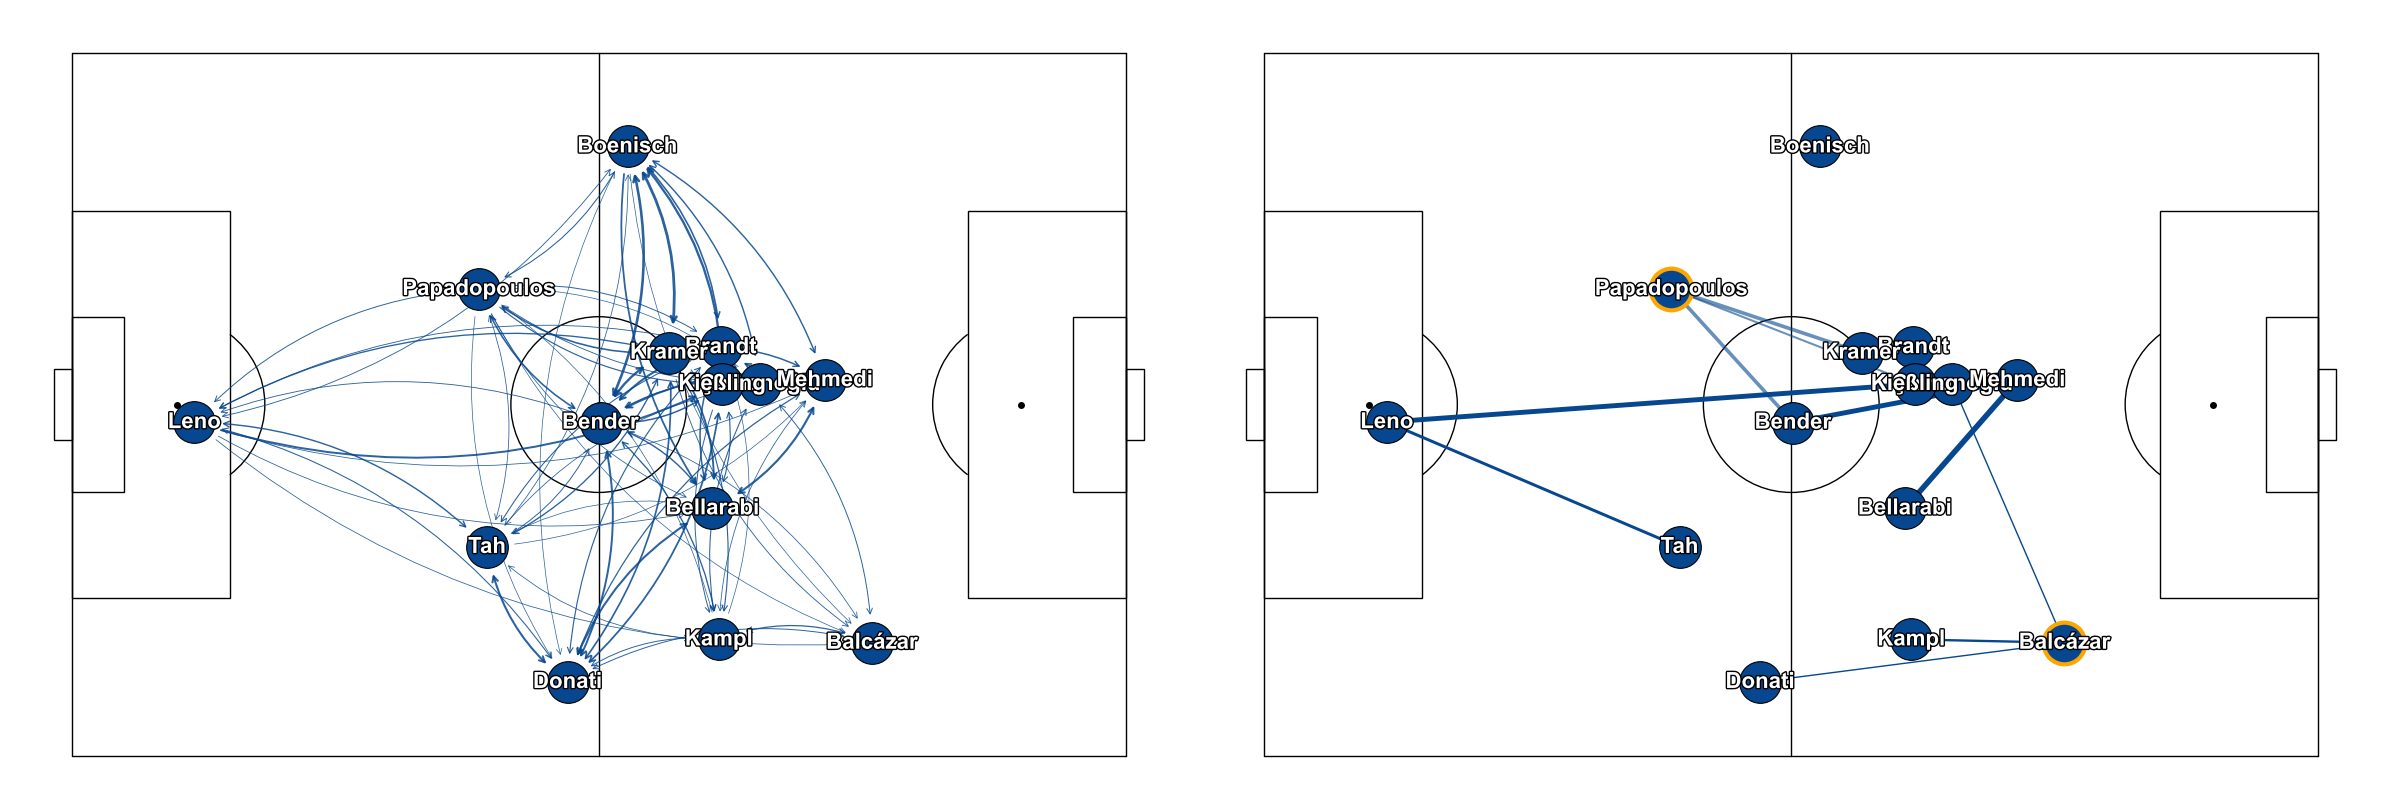

✓ Betweenness win visualization saved to: ..\viz\network_betweenness_win.png

Creating betweenness centrality - loss example...
ALMERÍA (L)
Barcelona vs Almería


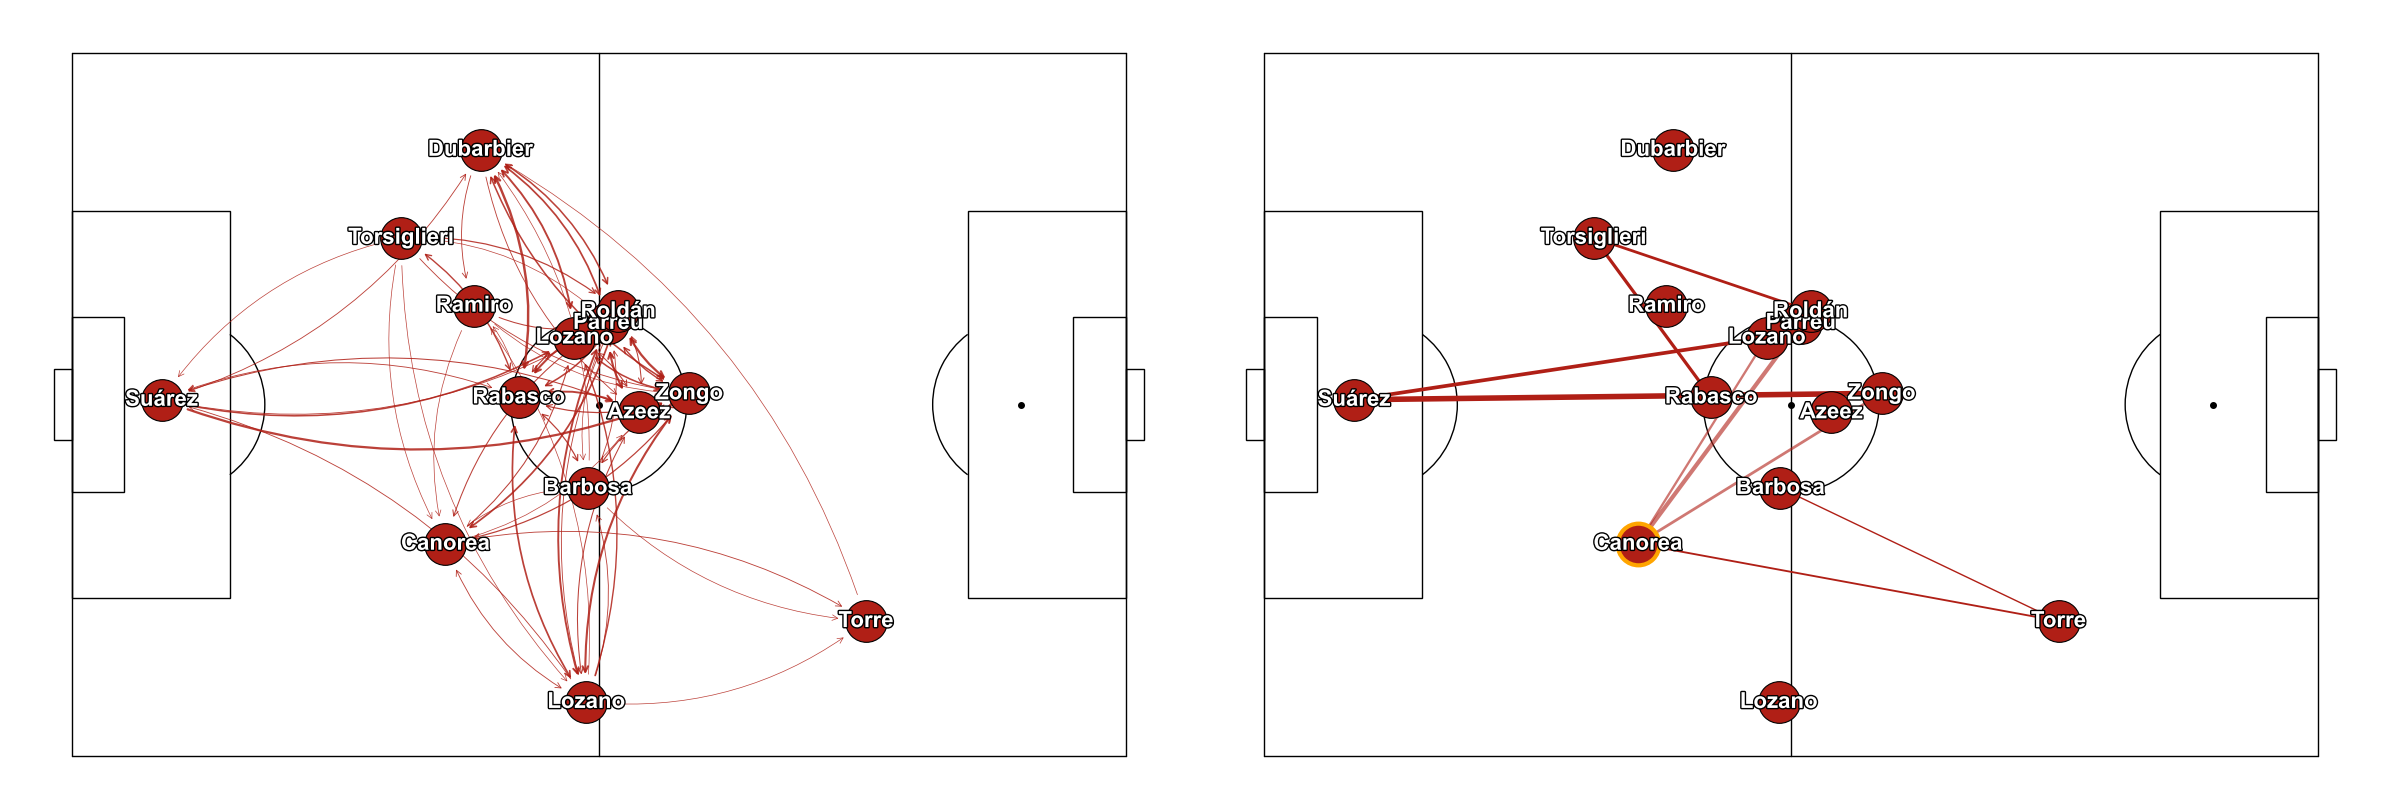

✓ Betweenness loss visualization saved to: ..\viz\network_betweenness_loss.png


In [ ]:
print("\n=== GENERATING BETWEENNESS ANALYSIS EXAMPLES ===")

print("\nCreating betweenness centrality - win example...")
fig_win, axes_win = visualize_betweenness_analysis(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_betweenness_win.png"
fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Betweenness win visualization saved to: {save_path}")
plt.close(fig_win)

print("\nCreating betweenness centrality - loss example...")
fig_loss, axes_loss = visualize_betweenness_analysis(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_betweenness_loss.png"
fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Betweenness loss visualization saved to: {save_path}")
plt.close(fig_loss)